In [372]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils

plt.style.use('ggplot')
%matplotlib inline

import importlib
utils = importlib.reload(utils)

In [408]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train, light_clean=False)
test = utils.clean_data(test, light_clean=False)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

data = pd.concat((train.drop('cardio', axis=1), test), axis=0)
dic = data.groupby('age_group_orig')['age'].mean().to_dict()
X_train['age_dif'] = X_train[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)
X_test['age_dif'] = X_test[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)
X_train['height_minus_weight'] = X_train['height'] - X_train['weight']
X_train['height_minus_weight_2'] = np.abs(X_train['height'] - X_train['weight'])

dic2 = data.groupby('age_group_orig')['age'].min().to_dict()
dic3 = data.groupby('age_group_orig')['age'].max().to_dict()
X_train['age_dif2'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif2']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

dic3 = data.groupby('age_group_orig')['age'].std().to_dict()
X_train['age_dif3'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif3']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

dic3 = (data.groupby('age_group_orig')['age'].max() - data.groupby('age_group_orig')['age'].min()).to_dict()
X_train['age_dif4'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif4']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

dic3 = (data.groupby('age_group_orig')['age'].max() - data.groupby('age_group_orig')['age'].min()).to_dict()
X_train['age_dif5'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / (1+dic3[x['age_group_orig']]), axis=1)
X_test['age_dif5']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / (1+dic3[x['age_group_orig']]), axis=1)

X_train['age_dif5'] += X_train['age_group']
X_test['age_dif5'] += X_test['age_group']
    
    
X_train['age_dif6'] = X_train['age_group'] + X_train['age_dif2']
X_test['age_dif6']  =  X_test['age_group'] + X_test['age_dif2']

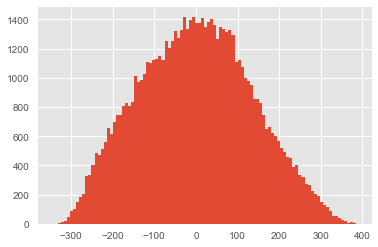

In [409]:
X_train['age_dif'].hist(bins=100)

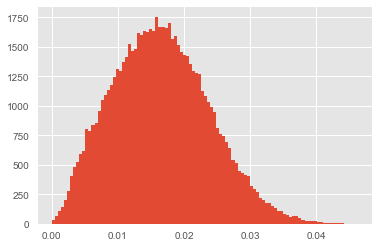

In [410]:
X_train['age_dif2'].hist(bins=100)

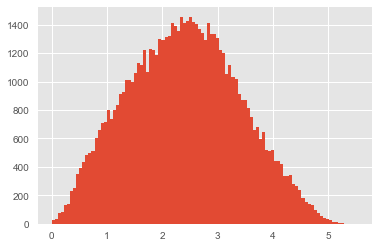

In [411]:
X_train['age_dif3'].hist(bins=100)

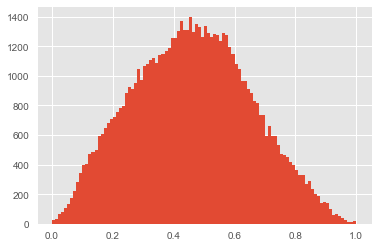

In [412]:
X_train['age_dif4'].hist(bins=100)

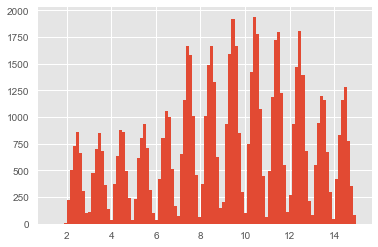

In [413]:
X_train['age_dif5'].hist(bins=100)

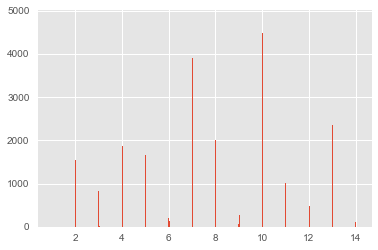

In [415]:
X_train['age_dif6'].hist(bins=1000)

In [382]:
loo_loss = pd.read_csv('loo_loss.csv', sep=';', header=None)
strat = pd.qcut(loo_loss, 20, labels=False).astype(str)
strat = np.hstack((strat, y_train.reshape((-1,1))))
strat =np.apply_along_axis(lambda d: str(d[0]) + '_' + str(d[1]), 1, strat)

In [416]:
use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
"active_fair",
"smoke_restored",
"alco_restored",
"height_mul_log_cholesterol",
"height_mul_log_gluc",
"BMI",
"age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
"ap_hi_mul_weight",
"age_dif5",
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
]
mean_columns = [


]

from sklearn.pipeline import Pipeline, FeatureUnion
from utils import SmoothLikelihood,SmoothLikelihood2,SmoothLikelihood3,SmoothLikelihood4, ColumnsFilter
def wrap_classifier(clf):
#     kf = StratifiedKFold(random_state=111111, n_splits=10, shuffle=True)
    fs = [("filter", ColumnsFilter(use_columns))]
    for i, cc in enumerate(mean_columns):
        fs.append(('mean_'+str(i), SmoothLikelihood4(cc, 0.5,
                                                    kf=StratifiedKFold(random_state=111111+i, n_splits=10, shuffle=True),
                                                    alpha=13,
                                                    seed=10+i,
                                                    std=0.000)))
    combined_features = FeatureUnion(fs)
    return Pipeline([ ("features", combined_features), ("model", clf)])

In [417]:
# y_train = y_train[(X_train['ap_hi']>50)&(X_train['ap_lo']>25)]
# strat=strat[(X_train['ap_hi']>50)&(X_train['ap_lo']>25)]
# X_train = X_train.loc[(X_train['ap_hi']>50)&(X_train['ap_lo']>25)]

In [ ]:
params = {
    'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
#               X_test,
#               model_name="model1-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
#                     verbose=0
             )
gc.collect()
# 10 folds logloss:
# [0.53684404710119704, 0.53718049849518756, 0.53644476209248393, 0.53561277117991202, 0.53673338604166798, 0.53859618834359368, 0.53827737755035221, 0.53749390188716761, 0.537133104824566, 0.53727048810209432]
# mean: 0.537158652562
# std: 0.000813836655103
# 15 Splits logloss:
# [0.53749522107413839, 0.53863472839746451, 0.53767700459524281, 0.53823132835133447, 0.53772297991652573, 0.53785062254317817, 0.53651734307053545, 0.53659968050693474, 0.53806024854488321, 0.53743641268568376, 0.5373041043694885, 0.53812405276333997, 0.53782112089012346, 0.53756818259445327, 0.53767867313981765]
# mean: 0.537648113563
# std: 0.000539074212487

#2
# 10 folds logloss:
# [0.53676760211035135, 0.53715491684485195, 0.53676678568497971, 0.53568982972936363, 0.53649877308545413, 0.53843685074438208, 0.53814939174766518, 0.53721822273882891, 0.53721999930367426, 0.53737258164544133]
# mean: 0.537127495363
# std: 0.000745526672666

#3
# 10 folds logloss:
# [0.53701183015343457, 0.53701988210425455, 0.53639460368788827, 0.53544136021234778, 0.53655452229166223, 0.53853152607321819, 0.53812342498339272, 0.53754730964537867, 0.53712501776688926, 0.53727101898267571]
# mean: 0.53710204959
# std: 0.00082987899831

#4
# 10 folds logloss:
# [0.53679438345154729, 0.53729395776659405, 0.53663317333014093, 0.53544036418896901, 0.53667273918653169, 0.53861525729142712, 0.53838812255030666, 0.53739726216400796, 0.53726910221958957, 0.5372631455194814]
# mean: 0.537176750767
# std: 0.000855910359479

In [ ]:
0.537269952732

In [226]:
import importlib
utils = importlib.reload(utils)

In [237]:
from utils import SmoothLikelihood4

D = X_train.copy()
G = X_test.copy()
slk = SmoothLikelihood4(['error_group'], 0.5, kf=StratifiedKFold(random_state=111111, n_splits=5, shuffle=True),
                        alpha=13,
                       seed=10,
                        std=0.0000
                       )
d1 = slk.fit_transform(X_train, y_train)
g1 = slk.transform(X_test)

In [238]:
D['slk']=d1
G['slk']=g1

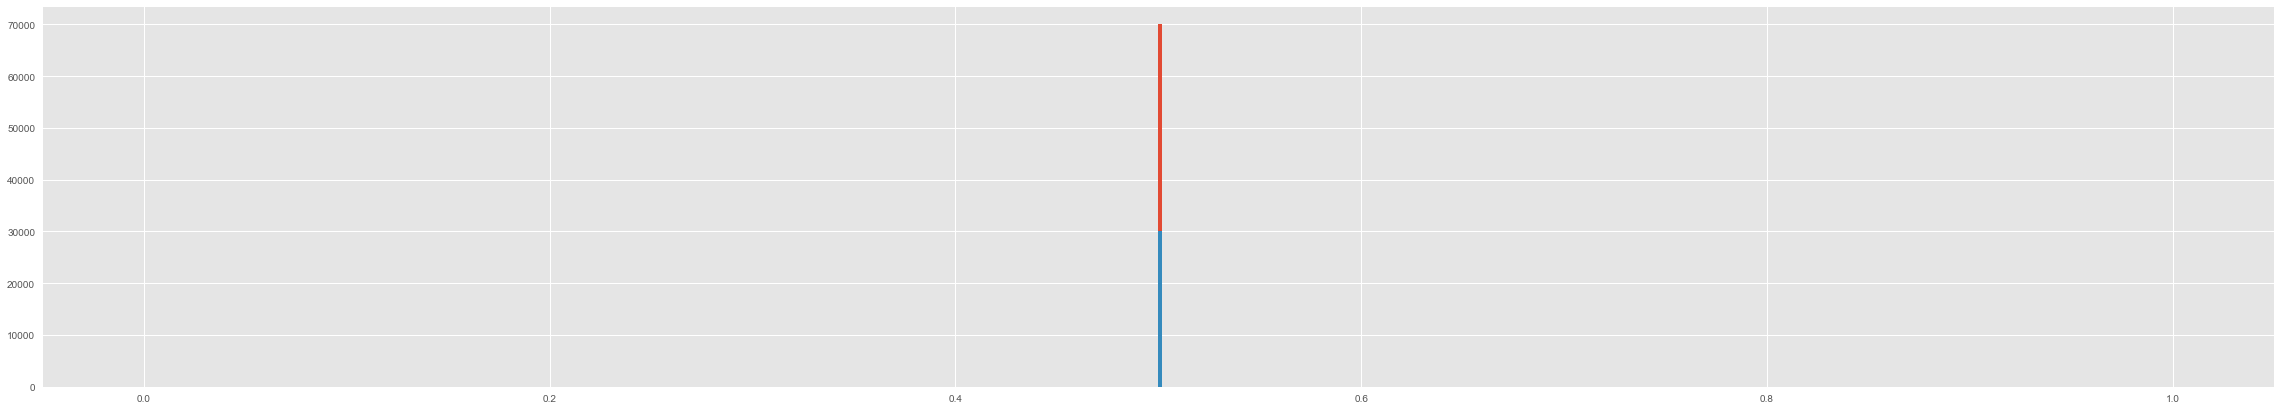

In [239]:
plt.figure(figsize=(40,7))
D['slk'].hist(bins=500)
G['slk'].hist(bins=500)

In [62]:
D.groupby(['ap_hi_group', 'age_group', 'gender'])['slk'].std().max()

0.054392829322042147

In [6]:
params = {
     'colsample_bytree': 0.95,
     'gamma': 0.55,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,

    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model2-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53621854076557018, 0.53671467667154171, 0.53785833236409908, 0.53887634320909306, 0.54040929569983065, 0.53854971592716183, 0.53593053353167508, 0.53796925385647876, 0.53776347541901204, 0.53742250891048571]
mean: 0.537771267635
std: 0.00125978114173
15 Splits logloss:
[0.53792029706149225, 0.53796479774568051, 0.53756138339918103, 0.53885004129557912, 0.53766862681623373, 0.53859242251391215, 0.53621256896543001, 0.53887050457378582, 0.53795376725122335, 0.53882877584262978, 0.53796384426632093, 0.53760679947114776, 0.53802274892754143, 0.53851110382457934, 0.5382489424028567]
mean: 0.538051774957
std: 0.00065647721665
model2- results saved!


138

In [7]:
import lightgbm as lgb

params = {
    'colsample_bytree': 0.95,
#      'gamma': 0.55,
     'learning_rate': 0.02,
#      'max_depth': 5,
     'num_leaves': 2**5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,
       
    'nthread': 4,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(lgb.LGBMClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model3-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53674828691443466, 0.53740081774898096, 0.53849129255010941, 0.53882538471335073, 0.540049613051651, 0.53907674070639899, 0.53585892069921393, 0.53816434662742074, 0.5381721388074262, 0.53751046821648107]
mean: 0.538029801004
std: 0.00114369314275
15 Splits logloss:
[0.53852821395001127, 0.53801697427516582, 0.53769298530942511, 0.53963810166474668, 0.53835073587024918, 0.53892591081315289, 0.53651119448287088, 0.5394750358892143, 0.53825725475911812, 0.53923570720354808, 0.53791071578963778, 0.53774567121550843, 0.53835163260492069, 0.53884289700829302, 0.5387461103420671]
mean: 0.538415276079
std: 0.000770252239898
model3- results saved!


133

In [20]:
clf = xgb.XGBClassifier(
        learning_rate=0.06,
        n_estimators=114,
        max_depth=5,
        min_child_weight=5,
        gamma=0.3,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=9,
        reg_lambda=1.4,
        nthread=4,
       
        seed=1111
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model4-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53684701946806423, 0.53904627581058673, 0.53925450638625105, 0.53989188552933032, 0.53915486433130788, 0.53996754890181486, 0.53685438735289981, 0.53911923948677121, 0.53806970960961065, 0.53829662128392108]
mean: 0.538650205816
std: 0.00105888278682
15 Splits logloss:
[0.53786308206546873, 0.53757894959336239, 0.53832602344400116, 0.5390815991984591, 0.5389430207432736, 0.53880189967403813, 0.53661770072153636, 0.53992167316040118, 0.5384940600400524, 0.53887855581886002, 0.53838546988332558, 0.53826701575570868, 0.53844438684678508, 0.53856093274589101, 0.53924811522094973]
mean: 0.538494165661
std: 0.000741658040147
model4- results saved!


360

In [8]:
clf = xgb.XGBClassifier(
        learning_rate=0.07,
        n_estimators=218,
        max_depth=3,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
        tree_method='hist',
        grow_policy='lossguide',
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model5-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53670905013243275, 0.53663060220198355, 0.5391350654835515, 0.539837075515748, 0.54015106013403613, 0.53894697401505498, 0.53691679622782151, 0.5387215399340789, 0.53726651191340424, 0.53865786091446444]
mean: 0.538297253647
std: 0.00124539071034
15 Splits logloss:
[0.53836993021491386, 0.53776298340294693, 0.5381327864122355, 0.53941939751174128, 0.53829588755548352, 0.53894926255409203, 0.53698739238899373, 0.53926021760595699, 0.53878827601431734, 0.53903658839834057, 0.53822160419404863, 0.53772581928924079, 0.53871668544065743, 0.5392587703452224, 0.53928808362533653]
mean: 0.538547578997
std: 0.000678594386135
model5- results saved!


354

In [22]:
clf = lgb.LGBMClassifier(
        learning_rate=0.07,
        n_estimators=218,
#         max_depth=3,
        num_leaves=2**3,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model6-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53729233228329154, 0.53824221983905107, 0.53925314271520197, 0.53967301022840231, 0.54101326975537467, 0.53878151429919197, 0.53722921025452586, 0.53908484341327723, 0.53750030455639575, 0.53849853217026511]
mean: 0.538656837951
std: 0.00112134847992
15 Splits logloss:
[0.53893002614750352, 0.53796856877313037, 0.53833071830764645, 0.53958581595393551, 0.53885994773688695, 0.53955169944489623, 0.53714436424151102, 0.53964319776051539, 0.53911891171222026, 0.53859584862403642, 0.53831491700316625, 0.53829827023891386, 0.53879225862120805, 0.53943793592587541, 0.53973409054781374]
mean: 0.538820438069
std: 0.000705708960613
model6- results saved!


349

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler  

# scaler = StandardScaler()  
# X = pd.concat((X_train, X_test), axis=0)
# scaler.fit(X)
# gc.collect()

# clf = MLPClassifier(solver='adam', activation='relu', learning_rate = 'adaptive', tol = 1e-5,
#                     hidden_layer_sizes=(8, 3), random_state=1100)

# utils.execute_model(clf,
#               scaler.transform(X_train),
#               y_train,
#               scaler.transform(X_test) ,
#               model_name="model4",
#               mean_columns = mean_columns,
#               use_columns = use_columns,
#               n_splits=15,
#               n_folds=10,
#               alpha=20
#              )
# gc.collect()

In [ ]:
models = ['model1','model2','model3']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234_mean.csv', index=False, header=False, sep=';')

In [12]:
models = ['KERAS_1', 'model1-','model2-','model5-','model1','model1+','model2+']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234-_mean.csv', index=False, header=False, sep=';')
# 0.537888791163	0.53818930228	0.537494736443	0.537712095482


KERAS_1
0.541188333484	0.541405679164	0.541188333484	0.541405679164

model1-
0.537495498978	0.537706445895	0.53815759386	0.538294889252

model2-
0.537771013645	0.538051774932	0.537698317632	0.53784253395

model5-
0.538296979367	0.538547578947	0.537626385479	0.537792961876

model1
0.538080079502	0.538009376104	0.537565135805	0.537666328327

model1+
0.537856175071	0.538141755107	0.537444703144	0.537562828916

model2+
0.538247526491	0.53857718903	0.537425694958	0.53755189076


In [ ]:
# 0.537557163108	0.537699150119 = 0.5428822 # + keras
# 0.537519393165	0.537619764695 = 0.5432057 * new log features

# 0.538126862768	0.538047373071 = 0.5431843
# 0.538084892954	0.538027778903 = 0.5433475
# 0.538157706723	0.538186899005 = 0.5430039 # без стасо-колонок
# 0.537450021945	0.537849282831 = 0.5434434
# 0.537513993512	0.537749328355 = 0.5433418

# 0.537790804547	0.538014148853 = 0.5438901 # overfit full

# 0.537368545033                   = 0.5428417
# 0.537561506209                   = 0.5432193
# 0.537449005194                   = 0.5428384


# 0.537727687638	0.537773366433 = 0.5437636
# 0.537662820586	0.538506869394 = 0.5433681
# 0.537639730851	0.538322959718 = 0.5436416 # overfit due to smoke leak
# 0.537723242359	0.538418956272 = 0.5433819
# 0.537697918691	0.538454608940 = 0.5435035
# 0.537797383673	0.538468964022 = 0.5433098
# 0.537998452494	0.538697384187 = 0.5433633
# 0.538141859286	0.538727942758 = 0.5434983


#--------------
0.5430039

In [ ]:
%%time
params = {
    'learning_rate': 0.1,
    'n_estimators': 50,
    
    'n_jobs': 8,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(),
              X_train,
              y_train,
              mean_columns = mean_columns,
              use_columns = use_columns,
              n_folds=10,
              alpha=13,
             )
gc.collect()

In [250]:
# 0.537735274001	0.537762262313 = 0.5439345
# 0.538040557134	0.538014744278 = 0.5436639
# 0.5374	0.5374                 = 0.5440495
# 0.537603843701	0.537606129043 = 0.5448082

# Со столбцами Стаса альфа=20
# 0.537387582699	0.537559051543 = 0.5482682

# 0.537684932504	0.537640948053 = 0.5514443 добавил один столбик "по Стасу"
# 0.537748490027	0.537673097079 = 0.5517563 20 фолдов для подсчета среднего

# Без них
# 0.538947547578	0.538808662263 = 0.5441786
# 0.538231869380	0.538120316604 = 0.5435621

In [309]:
features = [
(0.538315499209, 'age'),
(0.538287442456, 'gluc'),
(0.538173636312, 'smoke'),
(0.538198010197, 'alco'),
(0.538307514114, 'active'),
(0.538236151523, 'alco_fair'),
(0.538284434267, 'error_group'),
(0.538248549754, 'BMI_1'),
(0.53820942483, 'BMI_3'),
(0.538294944169, 'BMI_4'),
(0.538207337666, 'ap_dif'),
(0.538151853347, 'ap_dif_2'),
(0.538310067698, 'age_years'),
(0.538162316664, 'age_group_MAPX'),
(0.53830746832, 'ap_hi_group'),
(0.538241917485, 'ap_lo_group'),
(0.538040669841, 'ap_hi_group_2'),
(0.538252098393, 'ap_lo_group_2'),
(0.538212055457, 'weight_group'),
(0.53820596118, 'height_group'),
(0.53820596118, 'BMI_group'),
(0.538314903426, 'age_log'),
(0.53830738488, 'age_mul_age'),
(0.538314973583, 'age_mul_log_age'),
(0.538315427627, 'age_div_log_age'),
(0.538315499209, 'age_mul_age_group'),
(0.538315942012, 'age_mul_log_age_group'),
(0.538105165368, 'age_div_age_group'),
(0.53824842533, 'age_mul_weight'),
(0.538224409303, 'age_mul_log_weight'),
(0.538260527135, 'age_div_weight'),
(0.538204662914, 'age_mul_cholesterol'),
(0.538196349112, 'age_div_cholesterol'),
(0.538178013426, 'age_mul_gluc'),
(0.538120710241, 'age_mul_log_gluc'),
(0.538286503082, 'age_div_gluc'),
(0.538315499209, 'age_group_mul_age'),
(0.538302446793, 'age_group_mul_log_age'),
(0.538128629866, 'age_group_div_log_age'),
(0.538128768714, 'age_group_div_age'),
(0.538271481628, 'age_group_mul_height'),
(0.538199427798, 'age_group_mul_log_height'),
(0.538121055595, 'age_group_div_height'),
(0.538144348483, 'age_group_mul_weight'),
(0.538205379913, 'age_group_mul_log_weight'),
(0.538178771486, 'age_group_div_log_weight'),
(0.538167840212, 'age_group_div_weight'),
(0.53824754366, 'age_group_mul_ap_hi'),
(0.538290644407, 'age_group_div_log_ap_hi'),
(0.538260102673, 'age_group_div_ap_hi'),
(0.53813839963, 'age_group_mul_log_ap_lo'),
(0.538292448919, 'age_group_div_log_ap_lo'),
(0.538243009896, 'age_group_mul_cholesterol'),
(0.53821037313, 'age_group_mul_log_cholesterol'),
(0.538202715991, 'age_group_div_log_cholesterol'),
(0.538089492598, 'age_group_div_cholesterol'),
(0.538160908484, 'age_group_mul_gluc'),
(0.538219834415, 'age_group_div_log_gluc'),
(0.538232439398, 'age_group_div_gluc'),
(0.53816933296, 'age_group_mul_log_BMI'),
(0.538295109088, 'age_group_div_BMI'),
(0.538162316664, 'age_group_mul_MAP'),
(0.538101899195, 'age_group_mul_log_MAP'),
(0.538188266336, 'age_group_div_log_MAP'),
(0.538273168381, 'height_log'),
(0.53818394617, 'height_div_log_age'),
(0.538271481628, 'height_mul_age_group'),
(0.538206142627, 'height_div_age_group'),
(0.538273168381, 'height_mul_height'),
(0.538273168381, 'height_mul_log_height'),
(0.538273168381, 'height_div_log_height'),
(0.538227539026, 'height_div_weight'),
(0.538139027214, 'height_mul_log_ap_hi'),
(0.538292879256, 'height_div_ap_hi'),
(0.538234167161, 'height_mul_log_ap_lo'),
(0.538237227339, 'height_div_log_ap_lo'),
(0.53827291421, 'height_div_log_cholesterol'),
(0.538160064895, 'height_mul_gluc'),
(0.53815353107, 'height_div_log_gluc'),
(0.538188095088, 'height_div_gluc'),
(0.538248549754, 'height_mul_BMI'),
(0.538269299142, 'height_div_log_BMI'),
(0.538183822968, 'height_div_BMI'),
(0.53824842533, 'weight_mul_age'),
(0.538294891532, 'weight_div_log_age'),
(0.538144348483, 'weight_mul_age_group'),
(0.538165596201, 'weight_mul_log_age_group'),
(0.538259086569, 'weight_div_log_age_group'),
(0.538170771235, 'weight_div_age_group'),
(0.538206787218, 'weight_div_log_height'),
(0.538236580139, 'weight_mul_ap_hi'),
(0.538256465743, 'weight_div_ap_hi'),
(0.538305753176, 'weight_mul_ap_lo'),
(0.538301184352, 'weight_mul_log_ap_lo'),
(0.538283275873, 'weight_div_log_ap_lo'),
(0.538207268275, 'weight_div_ap_lo'),
(0.538149159101, 'weight_mul_log_cholesterol'),
(0.538297391761, 'weight_mul_log_gluc'),
(0.538267571542, 'weight_div_log_gluc'),
(0.538248549754, 'weight_mul_BMI'),
(0.538282460416, 'weight_div_BMI'),
(0.538314397095, 'weight_mul_MAP'),
(0.538248711078, 'weight_mul_log_MAP'),
(0.538135695691, 'ap_hi_log'),
(0.538130495293, 'ap_hi_div_log_age'),
(0.53824754366, 'ap_hi_mul_age_group'),
(0.538207064183, 'ap_hi_mul_log_age_group'),
(0.538292267562, 'ap_hi_div_log_age_group'),
(0.538187317514, 'ap_hi_div_age_group'),
(0.538164932288, 'ap_hi_div_log_height'),
(0.538236218383, 'ap_hi_div_height'),
(0.538106594764, 'ap_hi_div_weight'),
(0.538135847427, 'ap_hi_mul_ap_hi'),
(0.538135847427, 'ap_hi_mul_log_ap_hi'),
(0.538135695691, 'ap_hi_div_log_ap_hi'),
(0.538234906169, 'ap_hi_mul_log_ap_lo'),
(0.538297753183, 'ap_hi_div_log_ap_lo'),
(0.538122673806, 'ap_hi_div_ap_lo'),
(0.538233042328, 'ap_hi_mul_cholesterol'),
(0.538283922716, 'ap_hi_mul_log_cholesterol'),
(0.538270512725, 'ap_hi_div_log_cholesterol'),
(0.538100200598, 'ap_hi_div_cholesterol'),
(0.538281002655, 'ap_hi_mul_gluc'),
(0.538199901532, 'ap_hi_mul_log_gluc'),
(0.538161792908, 'ap_hi_div_log_gluc'),
(0.538180103849, 'ap_hi_div_gluc'),
(0.538215930469, 'ap_hi_mul_BMI'),
(0.538259060112, 'ap_hi_div_log_BMI'),
(0.538293900011, 'ap_hi_div_BMI'),
(0.538273593622, 'ap_hi_mul_log_MAP'),
(0.538233520287, 'ap_hi_div_log_MAP'),
(0.538252760606, 'ap_hi_div_MAP'),
(0.538307982316, 'ap_lo_log'),
(0.538222604797, 'ap_lo_div_log_age'),
(0.53828861088, 'ap_lo_div_age'),
(0.538301567411, 'ap_lo_div_log_age_group'),
(0.538311805784, 'ap_lo_div_age_group'),
(0.538115261609, 'ap_lo_mul_log_height'),
(0.538263938777, 'ap_lo_div_log_height'),
(0.538273649934, 'ap_lo_div_height'),
(0.538305753176, 'ap_lo_mul_weight'),
(0.538304687737, 'ap_lo_div_log_weight'),
(0.538128905999, 'ap_lo_mul_log_ap_hi'),
(0.53822186435, 'ap_lo_div_ap_hi'),
(0.538307980768, 'ap_lo_mul_ap_lo'),
(0.538307980768, 'ap_lo_mul_log_ap_lo'),
(0.538307982316, 'ap_lo_div_log_ap_lo'),
(0.538113196112, 'ap_lo_div_log_cholesterol'),
(0.538226047958, 'ap_lo_div_cholesterol'),
(0.538256128074, 'ap_lo_mul_gluc'),
(0.538281431482, 'ap_lo_mul_log_gluc'),
(0.538274630565, 'ap_lo_div_log_gluc'),
(0.538225512189, 'ap_lo_mul_BMI'),
(0.538240323261, 'ap_lo_mul_log_BMI'),
(0.538174916415, 'ap_lo_mul_MAP'),
(0.538248879493, 'ap_lo_mul_log_MAP'),
(0.538305951648, 'ap_lo_div_log_MAP'),
(0.538181088484, 'ap_lo_div_MAP'),
(0.538284434267, 'cholesterol_log'),
(0.538204662914, 'cholesterol_mul_age'),
(0.538151573366, 'cholesterol_mul_log_age'),
(0.538191022515, 'cholesterol_div_log_age'),
(0.53815816502, 'cholesterol_div_age'),
(0.538243009896, 'cholesterol_mul_age_group'),
(0.538184734661, 'cholesterol_div_log_age_group'),
(0.538097391347, 'cholesterol_div_age_group'),
(0.538255917395, 'cholesterol_div_height'),
(0.538252193885, 'cholesterol_div_log_weight'),
(0.538080087525, 'cholesterol_div_weight'),
(0.538233042328, 'cholesterol_mul_ap_hi'),
(0.538135317096, 'cholesterol_mul_log_ap_hi'),
(0.538139416461, 'cholesterol_div_log_ap_hi'),
(0.538110415665, 'cholesterol_div_ap_hi'),
(0.538215487654, 'cholesterol_div_log_ap_lo'),
(0.538234142767, 'cholesterol_div_ap_lo'),
(0.538284434267, 'cholesterol_mul_cholesterol'),
(0.538284434267, 'cholesterol_mul_log_cholesterol'),
(0.538284434267, 'cholesterol_div_log_cholesterol'),
(0.538195701726, 'cholesterol_mul_gluc'),
(0.538198193317, 'cholesterol_mul_log_gluc'),
(0.538237458466, 'cholesterol_div_gluc'),
(0.538293935994, 'cholesterol_div_log_BMI'),
(0.538222730462, 'cholesterol_div_BMI'),
(0.538201078479, 'cholesterol_mul_MAP'),
(0.538204652342, 'cholesterol_div_log_MAP'),
(0.538197501567, 'cholesterol_div_MAP'),
(0.538287442456, 'gluc_log'),
(0.538178013426, 'gluc_mul_age'),
(0.53827133389, 'gluc_div_log_age'),
(0.538287148425, 'gluc_div_age'),
(0.538160908484, 'gluc_mul_age_group'),
(0.538207367814, 'gluc_mul_log_age_group'),
(0.538208538209, 'gluc_div_log_age_group'),
(0.538080601041, 'gluc_div_age_group'),
(0.538160064895, 'gluc_mul_height'),
(0.538160087735, 'gluc_mul_log_height'),
(0.53815625939, 'gluc_div_height'),
(0.538281509568, 'gluc_mul_log_weight'),
(0.538301071547, 'gluc_div_weight'),
(0.538281002655, 'gluc_mul_ap_hi'),
(0.538255623321, 'gluc_mul_log_ap_hi'),
(0.538147646635, 'gluc_div_log_ap_hi'),
(0.538195246923, 'gluc_div_ap_hi'),
(0.538256128074, 'gluc_mul_ap_lo'),
(0.538241783233, 'gluc_mul_log_ap_lo'),
(0.538109792418, 'gluc_div_log_ap_lo'),
(0.538195701726, 'gluc_mul_cholesterol'),
(0.538180770041, 'gluc_mul_log_cholesterol'),
(0.538293752245, 'gluc_div_log_cholesterol'),
(0.538202119463, 'gluc_div_cholesterol'),
(0.538287442456, 'gluc_mul_gluc'),
(0.538287442456, 'gluc_mul_log_gluc'),
(0.538287442456, 'gluc_div_log_gluc'),
(0.538300100748, 'gluc_mul_BMI'),
(0.53827118749, 'gluc_mul_log_MAP'),
(0.538161825449, 'gluc_div_log_MAP'),
(0.538279652686, 'gluc_div_MAP'),
(0.538218068894, 'BMI_log'),
(0.538289935723, 'BMI_mul_log_age'),
(0.538211893763, 'BMI_div_log_age'),
(0.538302019612, 'BMI_div_age'),
(0.538220345839, 'BMI_mul_log_age_group'),
(0.538258849202, 'BMI_div_log_age_group'),
(0.538301789699, 'BMI_div_age_group'),
(0.538248549754, 'BMI_mul_height'),
(0.538249603142, 'BMI_mul_log_height'),
(0.538284019308, 'BMI_div_height'),
(0.538248549754, 'BMI_mul_weight'),
(0.538296371036, 'BMI_mul_log_weight'),
(0.538254239766, 'BMI_div_weight'),
(0.538215930469, 'BMI_mul_ap_hi'),
(0.538287765971, 'BMI_mul_log_ap_hi'),
(0.538248486839, 'BMI_div_log_ap_hi'),
(0.538200040497, 'BMI_div_ap_hi'),
(0.538225512189, 'BMI_mul_ap_lo'),
(0.538280904363, 'BMI_div_ap_lo'),
(0.538245647386, 'BMI_div_log_cholesterol'),
(0.538208600413, 'BMI_div_cholesterol'),
(0.538300100748, 'BMI_mul_gluc'),
(0.538284224719, 'BMI_mul_log_gluc'),
(0.538218068894, 'BMI_mul_BMI'),
(0.538218068894, 'BMI_mul_log_BMI'),
(0.538218068894, 'BMI_div_log_BMI'),
(0.538291178184, 'BMI_mul_MAP'),
(0.538244736377, 'BMI_mul_log_MAP'),
(0.538138707438, 'BMI_div_MAP'),
(0.538162316664, 'MAP_mul_age_group'),
(0.538216007835, 'MAP_div_log_age_group'),
(0.538283139466, 'MAP_div_age_group'),
(0.538314397095, 'MAP_mul_weight'),
(0.538282570279, 'MAP_div_log_weight'),
(0.538175072983, 'MAP_div_weight'),
(0.538267523476, 'MAP_div_log_ap_hi'),
(0.538223991417, 'MAP_div_ap_hi'),
(0.538174916415, 'MAP_mul_ap_lo'),
(0.538088499884, 'MAP_div_ap_lo'),
(0.538201078479, 'MAP_mul_cholesterol'),
(0.538252123281, 'MAP_div_log_cholesterol'),
(0.538169286714, 'MAP_div_cholesterol'),
(0.53831218631, 'MAP_mul_log_gluc'),
(0.538227324637, 'MAP_div_log_gluc'),
(0.538107129933, 'MAP_div_gluc'),
(0.538291178184, 'MAP_mul_BMI'),
(0.538302460313, 'MAP_mul_log_BMI'),
(0.538306504538, 'MAP_div_log_BMI'),
(0.538051375009, 'MAP_div_BMI'),
]

In [310]:
sorted(features)

[(0.538040669841, 'ap_hi_group_2'),
 (0.538051375009, 'MAP_div_BMI'),
 (0.538080087525, 'cholesterol_div_weight'),
 (0.538080601041, 'gluc_div_age_group'),
 (0.538088499884, 'MAP_div_ap_lo'),
 (0.538089492598, 'age_group_div_cholesterol'),
 (0.538097391347, 'cholesterol_div_age_group'),
 (0.538100200598, 'ap_hi_div_cholesterol'),
 (0.538101899195, 'age_group_mul_log_MAP'),
 (0.538105165368, 'age_div_age_group'),
 (0.538106594764, 'ap_hi_div_weight'),
 (0.538107129933, 'MAP_div_gluc'),
 (0.538109792418, 'gluc_div_log_ap_lo'),
 (0.538110415665, 'cholesterol_div_ap_hi'),
 (0.538113196112, 'ap_lo_div_log_cholesterol'),
 (0.538115261609, 'ap_lo_mul_log_height'),
 (0.538120710241, 'age_mul_log_gluc'),
 (0.538121055595, 'age_group_div_height'),
 (0.538122673806, 'ap_hi_div_ap_lo'),
 (0.538128629866, 'age_group_div_log_age'),
 (0.538128768714, 'age_group_div_age'),
 (0.538128905999, 'ap_lo_mul_log_ap_hi'),
 (0.538130495293, 'ap_hi_div_log_age'),
 (0.538135317096, 'cholesterol_mul_log_ap_hi'),


In [296]:
'ap_hi_group_3', 'ap_hi_group_4',
'ap_lo_group_3', 'ap_lo_group_4',
'age_dif', 'gluc'

'age_dif'

In [311]:
len(features)

266

In [312]:
0.538316696764-0.0001

0.538216696764

In [380]:
[f[1] for f in sorted(features) if f[0]<0.538216696764 and f[1] not in ['alco', 'active', 'smoke']]

['ap_hi_group_2',
 'MAP_div_BMI',
 'cholesterol_div_weight',
 'gluc_div_age_group',
 'MAP_div_ap_lo',
 'age_group_div_cholesterol',
 'cholesterol_div_age_group',
 'ap_hi_div_cholesterol',
 'age_group_mul_log_MAP',
 'age_div_age_group',
 'ap_hi_div_weight',
 'MAP_div_gluc',
 'gluc_div_log_ap_lo',
 'cholesterol_div_ap_hi',
 'ap_lo_div_log_cholesterol',
 'ap_lo_mul_log_height',
 'age_mul_log_gluc',
 'age_group_div_height',
 'ap_hi_div_ap_lo',
 'age_group_div_log_age',
 'age_group_div_age',
 'ap_lo_mul_log_ap_hi',
 'ap_hi_div_log_age',
 'cholesterol_mul_log_ap_hi',
 'ap_hi_div_log_ap_hi',
 'ap_hi_log',
 'ap_hi_mul_ap_hi',
 'ap_hi_mul_log_ap_hi',
 'age_group_mul_log_ap_lo',
 'BMI_div_MAP',
 'height_mul_log_ap_hi',
 'cholesterol_div_log_ap_hi',
 'age_group_mul_weight',
 'weight_mul_age_group',
 'gluc_div_log_ap_hi',
 'weight_mul_log_cholesterol',
 'cholesterol_mul_log_age',
 'ap_dif_2',
 'height_div_log_gluc',
 'gluc_div_height',
 'cholesterol_div_age',
 'gluc_mul_height',
 'height_mul_gluc'

In [ ]:
[
    'ap_hi_group_3', 'ap_hi_group_4',
'ap_lo_group_3', 'ap_lo_group_4',
'age_dif', 'gluc',
    'BMI_3',
 'BMI_div_MAP',
 'BMI_div_ap_hi',
 'BMI_div_cholesterol',
 'BMI_div_log_age',
 'BMI_group',
 'BMI_mul_ap_hi',
 'MAP_div_BMI',
 'MAP_div_ap_lo',
 'MAP_div_cholesterol',
 'MAP_div_gluc',
 'MAP_div_log_age_group',
 'MAP_div_weight',
 'MAP_mul_age_group',
 'MAP_mul_ap_lo',
 'MAP_mul_cholesterol',
 'age_div_age_group',
 'age_div_cholesterol',
 'age_group_MAPX',
 'age_group_div_age',
 'age_group_div_cholesterol',
 'age_group_div_height',
 'age_group_div_log_MAP',
 'age_group_div_log_age',
 'age_group_div_log_cholesterol',
 'age_group_div_log_weight',
 'age_group_div_weight',
 'age_group_mul_MAP',
 'age_group_mul_gluc',
 'age_group_mul_log_BMI',
 'age_group_mul_log_MAP',
 'age_group_mul_log_ap_lo',
 'age_group_mul_log_cholesterol',
 'age_group_mul_log_height',
 'age_group_mul_log_weight',
 'age_group_mul_weight',
 'age_mul_cholesterol',
 'age_mul_gluc',
 'age_mul_log_gluc',
 'ap_dif',
 'ap_dif_2',
 'ap_hi_div_age_group',
 'ap_hi_div_ap_lo',
 'ap_hi_div_cholesterol',
 'ap_hi_div_gluc',
 'ap_hi_div_log_age',
 'ap_hi_div_log_ap_hi',
 'ap_hi_div_log_gluc',
 'ap_hi_div_log_height',
 'ap_hi_div_weight',
 'ap_hi_group_2',
 'ap_hi_log',
 'ap_hi_mul_BMI',
 'ap_hi_mul_ap_hi',
 'ap_hi_mul_log_age_group',
 'ap_hi_mul_log_ap_hi',
 'ap_hi_mul_log_gluc',
 'ap_lo_div_MAP',
 'ap_lo_div_log_cholesterol',
 'ap_lo_mul_MAP',
 'ap_lo_mul_log_ap_hi',
 'ap_lo_mul_log_height',
 'cholesterol_div_MAP',
 'cholesterol_div_age',
 'cholesterol_div_age_group',
 'cholesterol_div_ap_hi',
 'cholesterol_div_log_MAP',
 'cholesterol_div_log_age',
 'cholesterol_div_log_age_group',
 'cholesterol_div_log_ap_hi',
 'cholesterol_div_log_ap_lo',
 'cholesterol_div_weight',
 'cholesterol_mul_MAP',
 'cholesterol_mul_age',
 'cholesterol_mul_gluc',
 'cholesterol_mul_log_age',
 'cholesterol_mul_log_ap_hi',
 'cholesterol_mul_log_gluc',
 'gluc_div_age_group',
 'gluc_div_ap_hi',
 'gluc_div_cholesterol',
 'gluc_div_height',
 'gluc_div_log_MAP',
 'gluc_div_log_age_group',
 'gluc_div_log_ap_hi',
 'gluc_div_log_ap_lo',
 'gluc_mul_age',
 'gluc_mul_age_group',
 'gluc_mul_cholesterol',
 'gluc_mul_height',
 'gluc_mul_log_age_group',
 'gluc_mul_log_cholesterol',
 'gluc_mul_log_height',
 'height_div_BMI',
 'height_div_age_group',
 'height_div_gluc',
 'height_div_log_age',
 'height_div_log_gluc',
 'height_group',
 'height_mul_gluc',
 'height_mul_log_ap_hi',
 'weight_div_age_group',
 'weight_div_ap_lo',
 'weight_div_log_height',
 'weight_group',
 'weight_mul_age_group',
 'weight_mul_log_age_group',
 'weight_mul_log_cholesterol']